In [20]:
import math
import os
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from luis_data_prep.NoiseGate import NoiseGate


# Create dataset: read in audio samples
# For each audio sample, use a sliding window to extract features
# output: X of features, y of labels
DATA_DIR = '../data'
notHidden = lambda x: not x.startswith('.')
classes = [d for d in os.listdir(DATA_DIR) if notHidden(d)]

X = []
y = []

win_size = 1    # in seconds
for i, c in enumerate(classes):
    wavs = filter(notHidden, os.listdir(os.path.join(DATA_DIR, c)))
    for w in wavs:
        path = os.path.join(DATA_DIR, c, w)
        sample, sampling_rate = librosa.load(path)

        win_length = win_size * sampling_rate
        n_fft = 2 ** math.ceil(math.log(win_length, 2))
        sgram = librosa.stft(sample, n_fft=n_fft, win_length=win_length, hop_length=win_length//2)
        xs = np.transpose(np.abs(sgram[:sampling_rate//2, :]))
        ys = np.ones((xs.shape[0], 1)) * i

        X.append(xs)
        y.append(ys)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

print(X.shape)
print(y.shape)

(1435, 11025)
(1435, 1)


In [ ]:
# View an arbitrary feature
i = 206
fig = plt.figure(figsize=(14,5))
plt.plot(X[i,:])
plt.title(classes[int(y[i])])

In [55]:
# Visualize multi-dimensional scaling of all the points without dimensionality reduction
from sklearn import manifold

def viewMds(X, y):
    embedding = manifold.MDS(
        n_components=2,
        max_iter=3000,          # about 2m30s
    )
    X_lowd = embedding.fit_transform(X)

    fig, ax = plt.subplots(figsize=(14, 14), facecolor="white", constrained_layout=True)
    Xx, Xy = X_lowd.T
    ax.scatter(Xx, Xy, c=y, alpha=0.8)


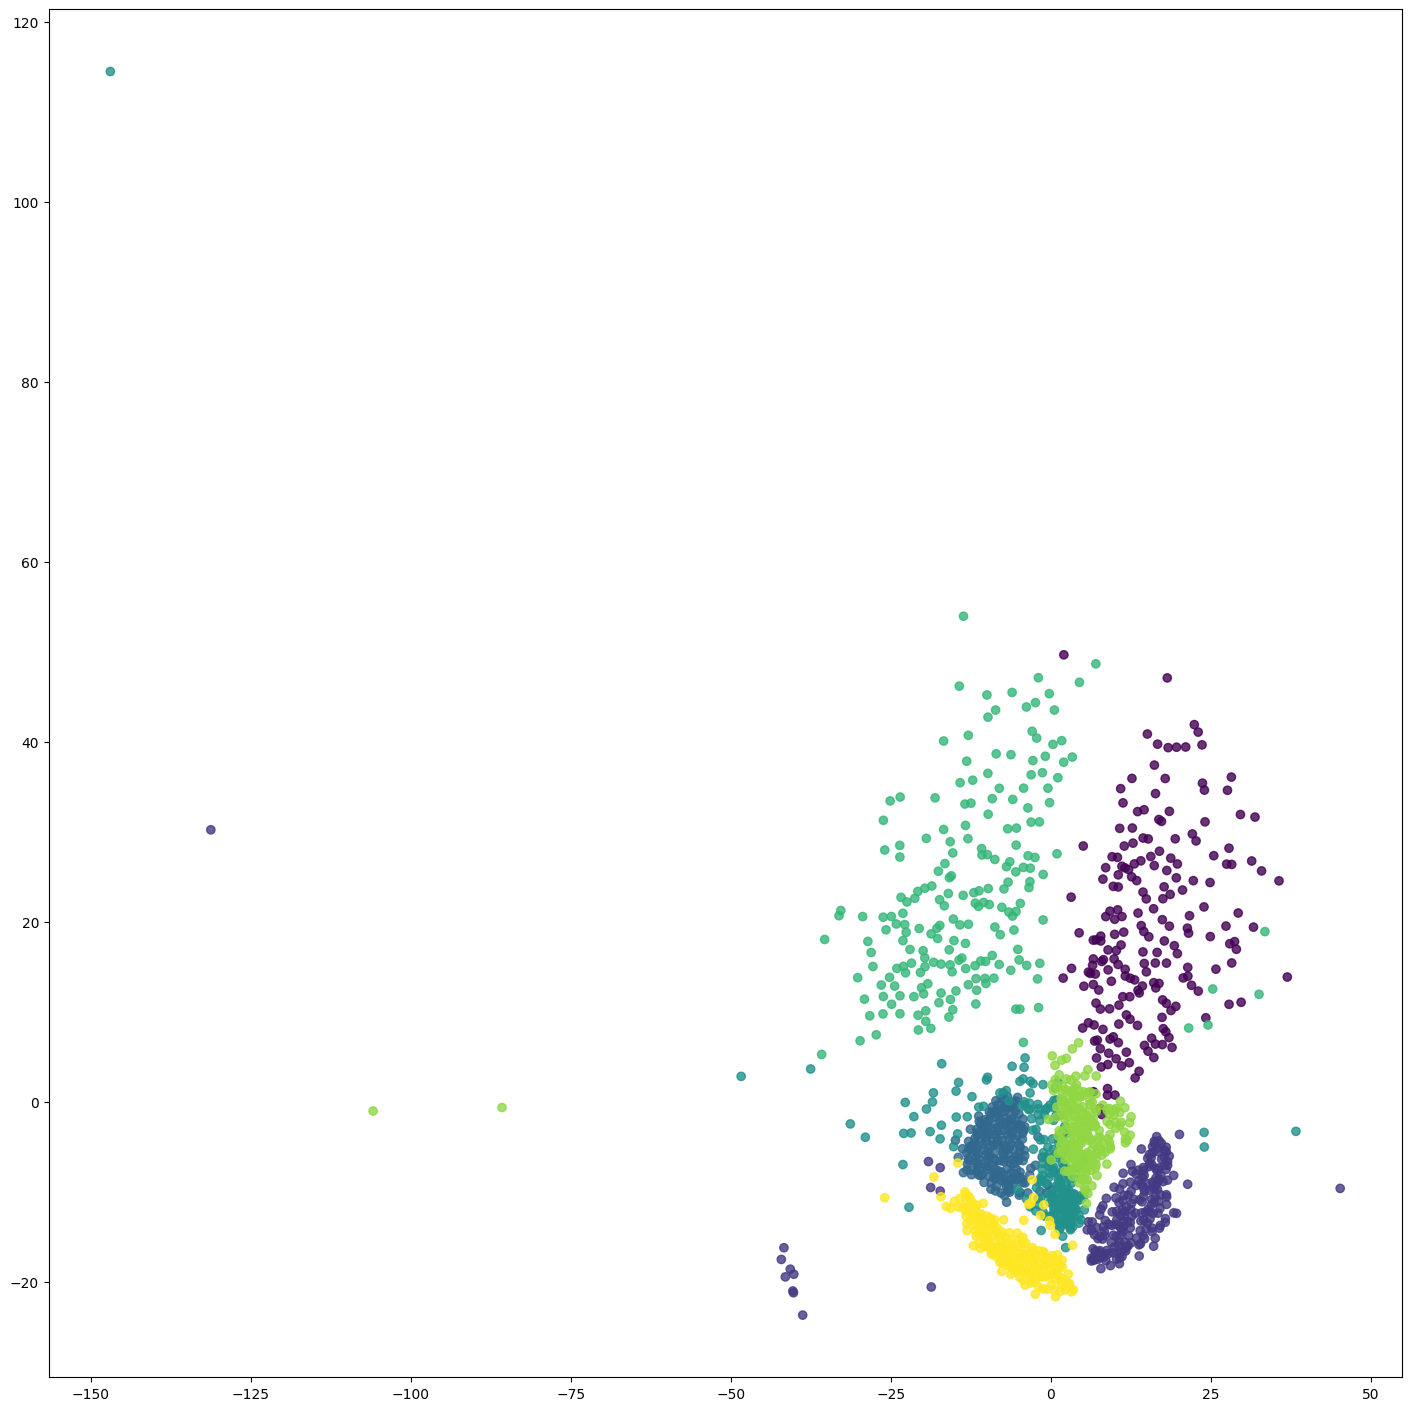

In [85]:
viewMds(X, y)

In [ ]:
# Dimensionality reduction via increasing the coarsness of the histogram
from scipy.stats import binned_statistic

n_bins = 50

freqs = np.linspace(0, X.shape[1], X.shape[1])
bins = np.linspace(0, X.shape[1], n_bins + 1)
bin_assignment = np.digitize(freqs, bins)                # Assign each index in the FFT result a bin

X_coarse = np.zeros((X.shape[0], n_bins))
for i in range(X.shape[0]):
    X_coarse[i, :] = np.array([X[i, bin_assignment == j].mean() for j in  range(1, len(bins))])

# Sanity check
plt.figure(figsize=(14,5))
plt.plot(X[450, :])
plt.figure(figsize=(14,5))
plt.plot(X_coarse[450,:])

In [ ]:
viewMds(X_coarse, y)

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get cross-validation score
n_samples_per_class = 5
dp_per_sample = 41

# Fix with different classes
def crossValidate(X, y, train, test):
    predictions = []
    true_labels = []
    for test_i in range(n_samples_per_class * len(classes)):
        X_train = np.concatenate([X[:test_i*dp_per_sample, :], X[(test_i + 1)*dp_per_sample:, :]], axis=0)
        X_test = X[test_i*dp_per_sample:(test_i + 1)*dp_per_sample]
        y_train = np.concatenate([y[:test_i*dp_per_sample], y[(test_i + 1)*dp_per_sample:]], axis=0)
        y_test = y[test_i*dp_per_sample:(test_i + 1)*dp_per_sample]

        model = train(X_train, np.ravel(y_train))
        y_pred = test(X_test, model)
        predictions.append(y_pred)
        true_labels.append(y_test)

    confusions = confusion_matrix(np.concatenate(true_labels), np.concatenate(predictions))
    return np.array(confusions)

def disp(confusions):
    plt.figure(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusions)
    disp.plot()
    plt.show()

    overall_acc = sum(confusions.diagonal())/(205*7)
    print('Overall accuracy: ', overall_acc)



<Figure size 1000x700 with 0 Axes>

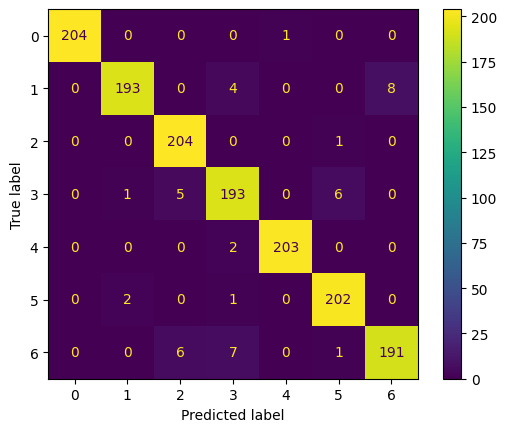

Overall accuracy:  0.9686411149825784


In [136]:
from sklearn.neighbors import KNeighborsClassifier

def trainKnn(X, y):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X, y)
    return neigh

def testKnn(X, model):
    predicted = model.predict(X)
    return predicted

disp(crossValidate(X, y, trainKnn, testKnn))


<Figure size 1000x700 with 0 Axes>

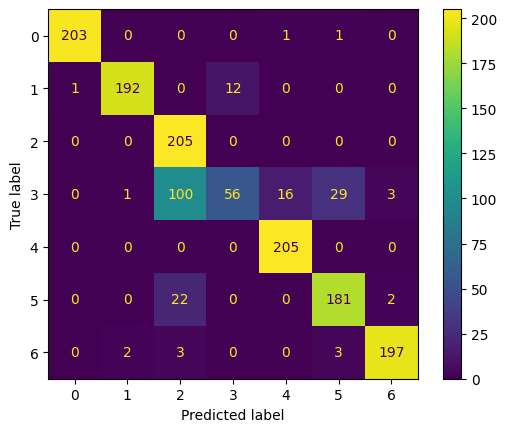

Overall accuracy:  0.8634146341463415


In [137]:
from sklearn.naive_bayes import GaussianNB

# Fits a multidimensional Gaussian to each class.
def trainGnb(X, y):
    gnb = GaussianNB()
    model = gnb.fit(X, y)
    return model

def testGnb(X, model):
    predicted = model.predict(X)
    return predicted

disp(crossValidate(X, y, trainGnb, testGnb))

# To do: throw out outliers?

<Figure size 1000x700 with 0 Axes>

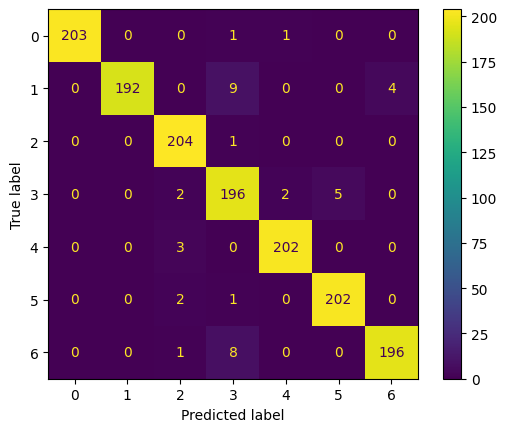

Overall accuracy:  0.9721254355400697


In [138]:
# Multiclass linear SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def trainLinSvms(X, y):
    svms = OneVsRestClassifier(SVC(kernel='linear', C=2))
    return svms.fit(X, y)

def testLinSvms(X, model):
    predicted = model.predict(X)
    return predicted

disp(crossValidate(X_coarse, y, trainLinSvms, testLinSvms))

<Figure size 1000x700 with 0 Axes>

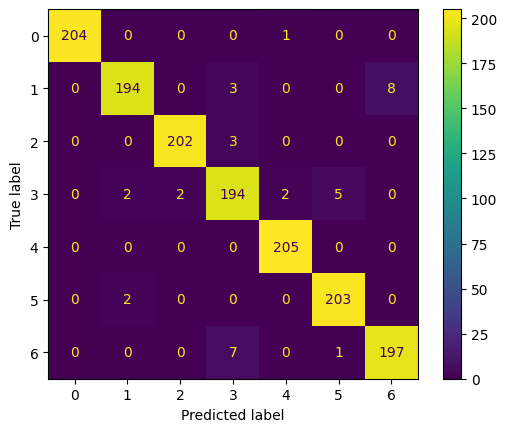

Overall accuracy:  0.9749128919860627


In [139]:
# Multiclass RBF SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def trainLinSvms(X, y):
    svms = OneVsRestClassifier(SVC(kernel='rbf', C=2, gamma='scale'))
    return svms.fit(X, y)

def testLinSvms(X, model):
    predicted = model.predict(X)
    return predicted

disp(crossValidate(X_coarse, y, trainLinSvms, testLinSvms))